### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
plt.rcParams.update({'font.size': 17})

### Dataloading Methods

In [108]:
def get_target_predictions(results_file):
    predictions = []
    with open(results_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Target prediction' in line and not 'retraining' in line:
                prediction = line[line.find('[[')+2:line.find(']]')]
                prediction_vals = prediction.split(', ')
                predictions.append(float(prediction_vals[0]))
    return predictions[:10]

def get_network_results(path):
    results = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            epoch = int(line[0].split(': ')[1])
            loss = float(line[1].split(': ')[1])
            fake_correct = int(line[2].split(': ')[1])
            fake_incorrect = int(line[3].split(': ')[1])
            real_correct = int(line[4].split(': ')[1])
            real_incorrect = int(line[5].split(': ')[1])
            results.append((epoch, loss, fake_correct, fake_incorrect, real_correct, real_incorrect))
    return results

def get_output_results(file):
    results = []
    with open(file, 'r') as f:
        while line := f.readline():
            if 'Finished evaluation' in line:
                real_correct, real_incorrect, fake_correct, fake_incorrect, loss = line[line.find(':')+2:].split()
                real_correct, real_incorrect, fake_correct, fake_incorrect = int(real_correct), int(real_incorrect), int(fake_correct), int(fake_incorrect)
                loss = float(loss)
                results.append((loss, fake_correct, fake_incorrect, real_correct, real_incorrect))
    return results

def get_accuracies(results_file):
    accuracies = []
    results = get_output_results(results_file)
    for result in results:
        fake_correct = result[1]
        fake_incorrect = result[2]
        real_correct = result[3]
        real_incorrect = result[4]
        accuracy = (fake_correct + real_correct)/(fake_correct + fake_incorrect + real_correct + real_incorrect)
        accuracies.append(accuracy)
    return accuracies

def get_poison_target_feature_dist(file):
    dists = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Poison-target' in line:
                dist = float(line[line.find(':')+2:])
                dists.append(dist)
            if 'created' in line:
                return dists
            if 'too far' in line:
                dists = []
    return dists

def get_poison_base_dist(file):
    dists = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Poison-base' in line:
                dist = float(line[line.find(':')+2:])
                dists.append(dist)
            if 'created' in line:
                return dists
            if 'too far' in line:
                dists = []
    return dists

def get_orginal_target_pred(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Original target prediction' in line:
                start = line.find('[[')+2
                end = line[line.find('[[')+2:].find(',')
                return float(line[start:start+end])
    return -10000

def get_final_target_pred(file):
    last_pred = -100000
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Target prediction after retraining from scratch' in line:
                start = line.find('[[')+2
                end = line[line.find('[[')+2:].find(',')
                return float(line[start:start+end])
            elif "Target prediction" in line:
                start = line.find('[[')+2
                end = line[line.find('[[')+2:].find(',')
                last_pred = float(line[start:start+end])
    return last_pred

### Graphing methods

In [292]:
def graph_target_class(file, log=False):
    predictions = get_target_predictions(file)
    epochs = range(1, len(predictions)+1)
    plt.plot(epochs, predictions)
    if log:
        plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Probability of real class')
    plt.title('Target classification per epoch')
    plt.legend()
    plt.show()
    
def graph_target_class_multiple(files, log=False, title=None, const=None):
    for file in files:
        predictions = get_target_predictions(file)
        epochs = range(1, len(predictions)+1)
        plt.plot(epochs, predictions)
    if log:
        plt.yscale('log')
    if const:
        plt.axhline(y = const, color='red', linestyle = 'dashed') 
    plt.xlabel('Epoch')
    plt.ylabel('Probability of real class')
    plt.xticks(epochs)
    if title:
        plt.title(title)
    else:
        plt.title('Target classification per epoch')
    plt.show()

def graph_accuracy(file, log=False):
    accuracies = get_accuracies(file)
    epochs = range(1, len(accuracies)+1)
    plt.plot(epochs, accuracies)
    if log:
        plt.yscale('log')
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Network accuracy per epoch')
    plt.show()
    
def graph_accuracy_multiple(files, log=False, name=None):
    for file in files:
        accuracies = get_accuracies(file)
        epochs = range(1, len(accuracies)+1)
        plt.plot(epochs, accuracies)
    if log:
        plt.yscale('log')
    if name:
        plt.title(name)
    else:
        plt.title('Network accuracy per epoch')
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
def graph_poison_distances(files, iterations, name="Poison Distances"):
    target_dists = [get_poison_target_feature_dist(file) for file in files]
    base_dists = [get_poison_base_dist(file) for file in files]
    minimum = sorted([len(get_poison_target_feature_dist(file)) for file in files]
                            + [len(get_poison_base_dist(file)) for file in files])[0]
    x = range(0, iterations, 100)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in range(len(files)):
        ax1.plot(x, target_dists[i][:minimum], 'g-', label='Target')
        ax2.plot(x, base_dists[i][:minimum], 'b-', label='Base')
    
    ax1.set_yscale('log')
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Target distance', color='g')
    ax2.set_ylabel('Base distance', color='b')
    plt.title(name)
    plt.show()

def graph_target_class_accuracy(file, original_pred=False):
    accuracies = get_accuracies(file)
    predictions = get_target_predictions(file)
    print(accuracies, predictions)
    epochs = range(1, len(accuracies)+1)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, predictions, label='Prediction')
    if original_pred:
        or_pred = get_orginal_target_pred(file)
        plt.axhline(y = or_pred, color='red', linestyle = 'dashed') 
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy/Prediction')
    plt.title(f'Network accuracy and target prediction')
    plt.legend()
    plt.show()

### Data paths

In [229]:
meso_face_outputs = [
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630327',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630330',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634167',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634168',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634169',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634170',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634899',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634900']

xception_full_base_20_outputs = [
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876787',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876788',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876789',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876791',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876793',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876794',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876795',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876796']

xception_full_base_50_outputs = [
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40111805',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40111942',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40124036',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143603',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143604',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143605',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143606',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143607']

xception_full_base_v2_outputs = [
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020483',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020484',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020485',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020487',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051567',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051568',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051569',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051567']

xception_face_base_v2_outputs = [
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258435',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258443',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258445',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258447',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401530',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401532',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401534',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401536']

meso_face_base_v2_outputs = [
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630327',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630330',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634167',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634168',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634169',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634170',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634899',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634900']

full_finetune = [
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41851576',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863660',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863661',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863677',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863678',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41895996',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41895997',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41895998'
]

face_finetune = [
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41790764',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41790769',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41824482',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41824483',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41836648',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41879477',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41879478',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41879479']

### Graphs

#### Baseline 20 poisons

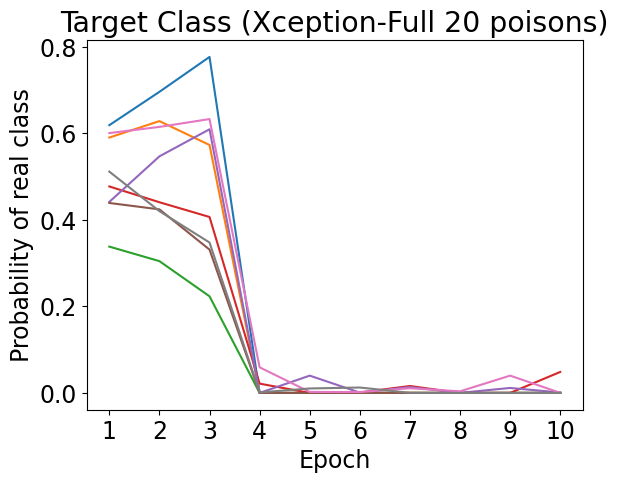

In [230]:
graph_target_class_multiple(xception_full_base_20_outputs, title="Target Class (Xception-Full 20 poisons)")

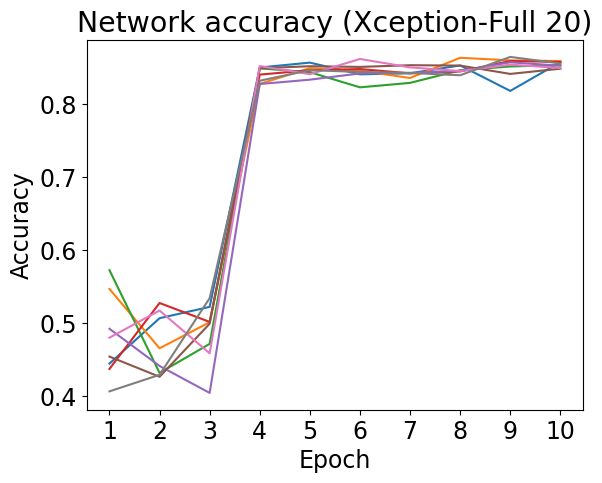

In [231]:
graph_accuracy_multiple(xception_full_base_20_outputs, name='Network accuracy (Xception-Full 20)')

#### Baseline 50 poisons

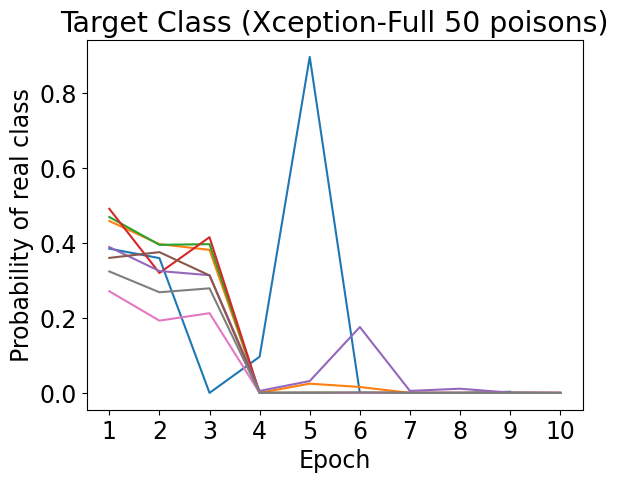

In [232]:
graph_target_class_multiple(xception_full_base_50_outputs, title="Target Class (Xception-Full 50 poisons)")

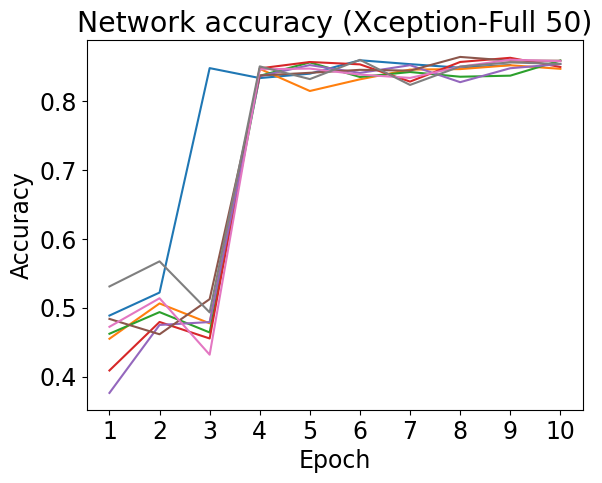

In [233]:
graph_accuracy_multiple(xception_full_base_50_outputs, name='Network accuracy (Xception-Full 50)')

#### Baseline v2 Xception-Full

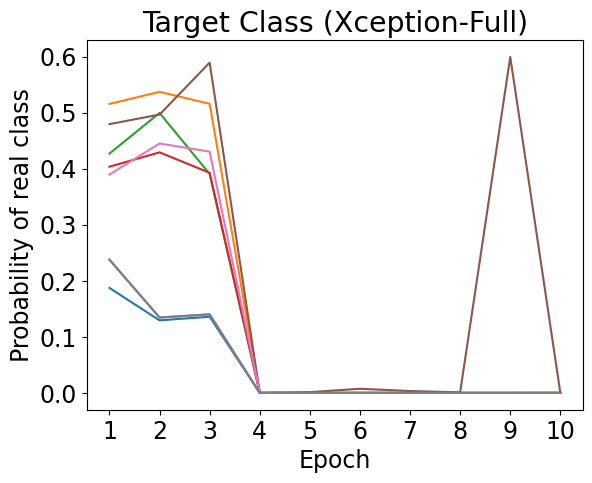

In [234]:
graph_target_class_multiple(xception_full_base_v2_outputs, title="Target Class (Xception-Full)")

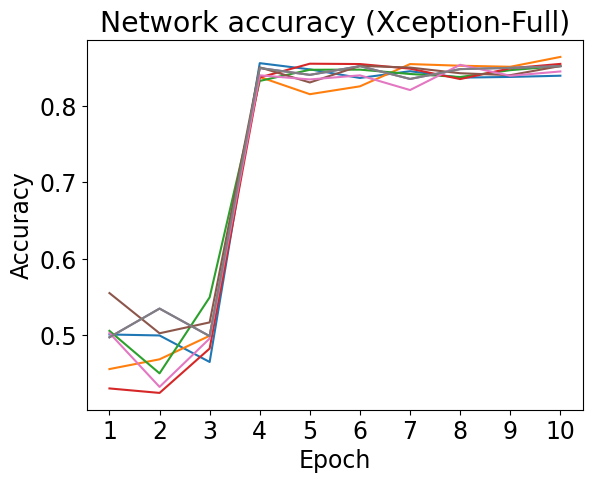

In [235]:
graph_accuracy_multiple(xception_full_base_v2_outputs, name='Network accuracy (Xception-Full)')

#### Baseline v2 Xception-Face

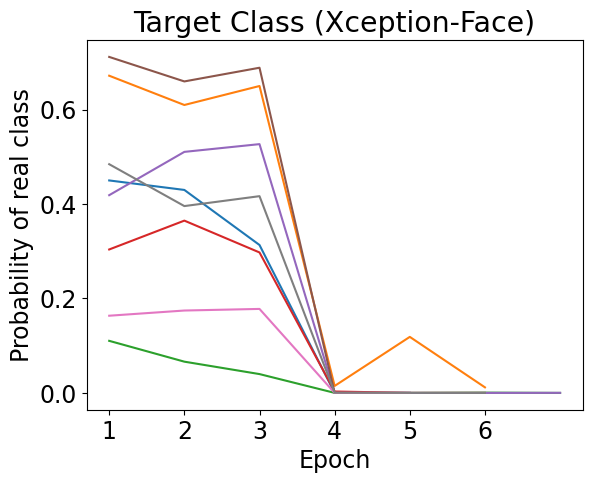

In [236]:
graph_target_class_multiple(xception_face_base_v2_outputs, title="Target Class (Xception-Face)")

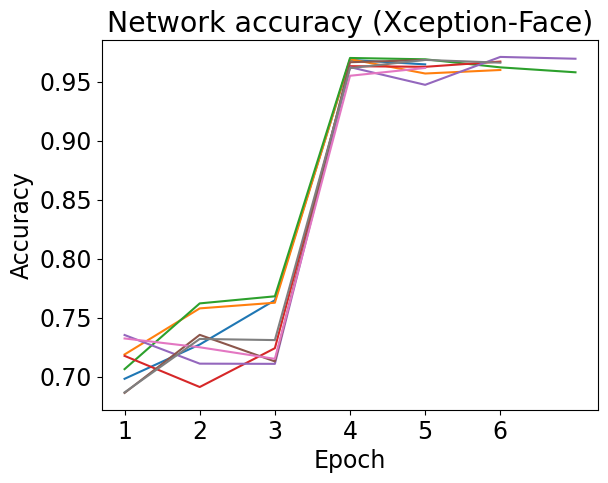

In [237]:
graph_accuracy_multiple(xception_face_base_v2_outputs, name='Network accuracy (Xception-Face)')

#### Baseline v2 Meso-Face

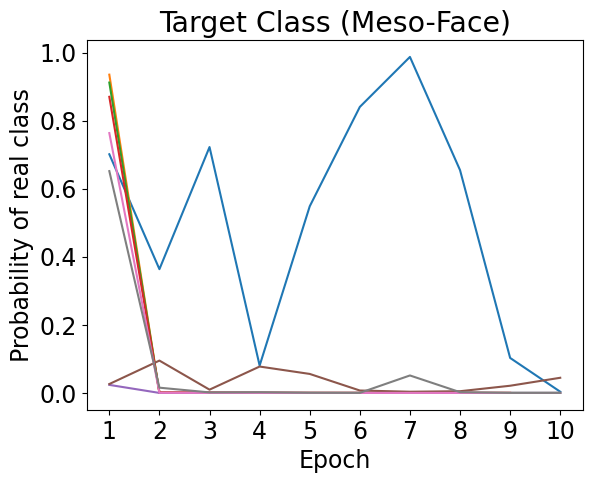

In [238]:
graph_target_class_multiple(meso_face_base_v2_outputs, title="Target Class (Meso-Face)")

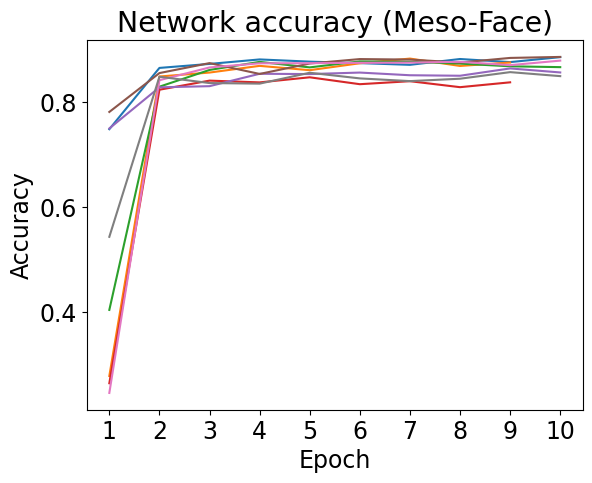

In [239]:
graph_accuracy_multiple(meso_face_base_v2_outputs, name='Network accuracy (Meso-Face)')

#### Finetune Full

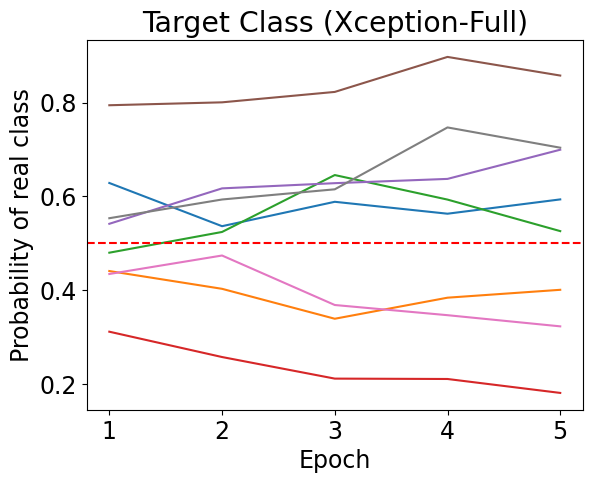

In [240]:
graph_target_class_multiple(full_finetune, title="Target Class (Xception-Full)", const=0.5)

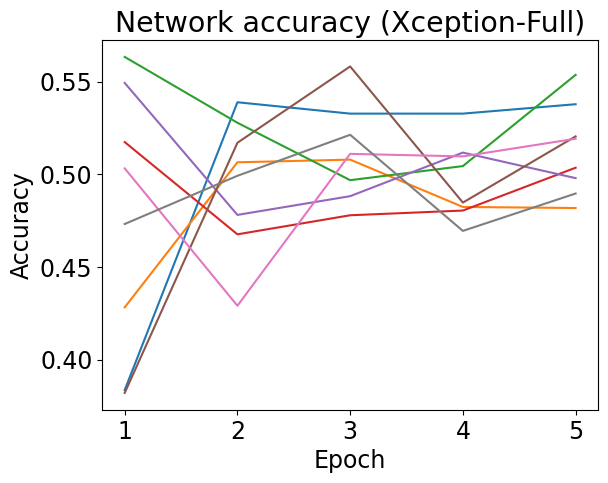

In [241]:
graph_accuracy_multiple(full_finetune, name='Network accuracy (Xception-Full)')

#### Finetune Face

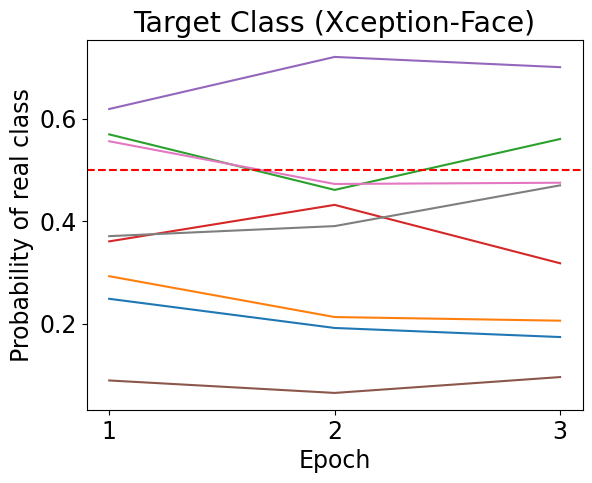

In [242]:
graph_target_class_multiple(face_finetune, title="Target Class (Xception-Face)", const=0.5)

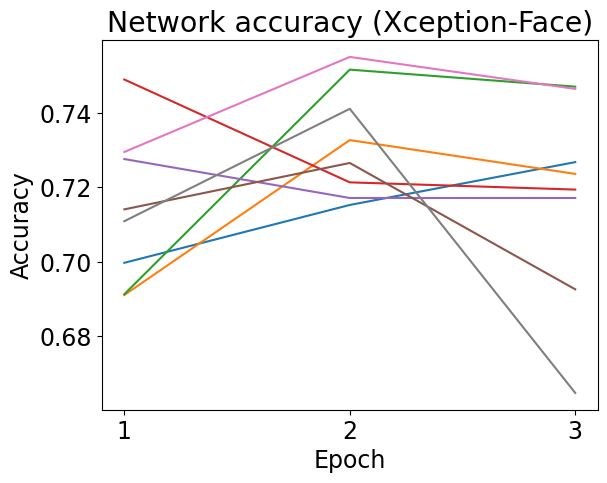

In [243]:
graph_accuracy_multiple(face_finetune, name='Network accuracy (Xception-Face)')

[0.6997603560424512, 0.7152864949852283, 0.7267805292454386] [0.2484, 0.1915, 0.1738]


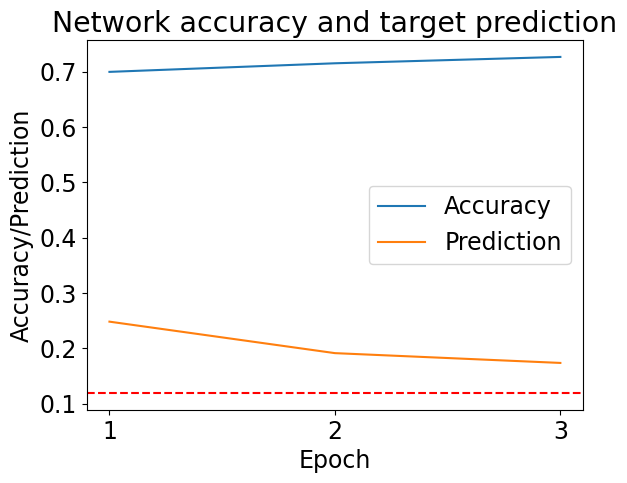

In [244]:
graph_target_class_accuracy(face_finetune[0], original_pred=True)

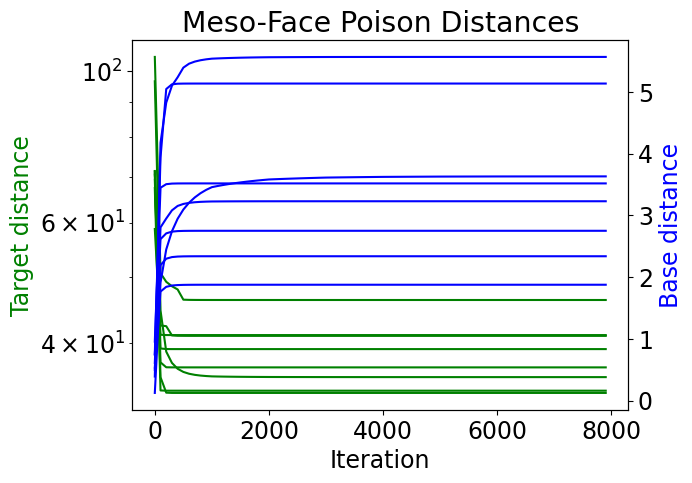

In [302]:
graph_poison_distances(meso_face_base_v2_outputs,8000,name='Meso-Face Poison Distances')

### Numeric Results

#### Meso Base 2

In [275]:
results_before = [get_orginal_target_pred(file) for file in meso_face_base_v2_outputs]
results_after = [get_final_target_pred(file) for file in meso_face_base_v2_outputs]
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

(0.0049660469509625,
 0.006030036231527125,
 0.004277698233743276,
 0.00515638529882357,
 1.214252763026819,
 0.0010639892805646245,
 0.0008801682796263088)

#### Xception-Face Base 2

In [276]:
results_before = [get_orginal_target_pred(file) for file in xception_face_base_v2_outputs]
results_after = [get_final_target_pred(file) for file in xception_face_base_v2_outputs]
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

(0.00046284916527438737,
 0.00149789972165725,
 0.00043258252995688137,
 0.001376824200319572,
 3.236258880945073,
 0.0010350505563828626,
 0.0009443107304626767)

#### Xception-Full Base 2

In [248]:
results_before = [get_orginal_target_pred(file) for file in xception_full_base_v2_outputs]
results_after = [get_final_target_pred(file) for file in xception_full_base_v2_outputs]
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

(0.004612633102575891,
 2.4929214024999998e-05,
 0.004314580887875224,
 1.2404053770615564e-05,
 0.0054045516889428,
 -0.004587703888550891,
 0.004315141206327691)

#### Xception-Full Base 20

In [249]:
results_before = [get_orginal_target_pred(file) for file in xception_full_base_20_outputs]
results_after = [get_final_target_pred(file) for file in xception_full_base_20_outputs]
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

(0.0005262408678931326,
 0.006219513991375,
 0.00031433608426569855,
 0.005650948058814308,
 11.818758995810338,
 0.005693273123481867,
 0.0053866303265067425)

#### Xception-Full Base 50

In [250]:
results_before = [get_orginal_target_pred(file) for file in xception_full_base_50_outputs]
results_after = [get_final_target_pred(file) for file in xception_full_base_50_outputs]
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

(0.00019400753816973713,
 0.00043238586570124997,
 0.00010549472232662033,
 0.0003571672149272291,
 2.228706522336033,
 0.00023837832753151287,
 0.0003972401159346129)

#### Xception-Full Finetune

In [277]:
results_before = [get_orginal_target_pred(file) for file in full_finetune]
results_after = [get_final_target_pred(file) for file in full_finetune]
print(results_before, '\n', results_after)
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

[0.7107, 0.3791, 0.4326, 0.248, 0.7018, 0.7869, 0.4031, 0.6752] 
 [0.5936, 0.4009, 0.526, 0.1811, 0.6995, 0.8576, 0.323, 0.7038]


(0.5421750000000001,
 0.5356875,
 0.06566340721341682,
 0.07408901410950715,
 0.9880343062664267,
 -0.006487499999999997,
 0.024776459577969367)

#### Xception-Face Finetune

In [258]:
results_before = [get_orginal_target_pred(file) for file in face_finetune]
results_after = [get_final_target_pred(file) for file in face_finetune]
print(results_before, '\n', results_after)
before = np.average(results_before)
after = np.average(results_after)
std_before = np.std(results_before)/np.sqrt(len(results_before))
std_after = np.std(results_after)/np.sqrt(len(results_after))
rel = after/before
ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
mean_ab = np.average(ab)
std_ab = np.std(ab)/np.sqrt(len(ab))
before, after, std_before, std_after, rel, mean_ab, std_ab

[0.1172, 0.1656, 0.3522, 0.1726, 0.726, 0.1395, 0.3117, 0.5116] 
 [0.1738, 0.2057, 0.5601, 0.3177, 0.7002, 0.0957, 0.4748, 0.4697]


(0.31205000000000005,
 0.3747125,
 0.0708674907838566,
 0.06952744835112785,
 1.2008091651978847,
 0.0626625,
 0.03274345801788122)

#### Graph results

In [281]:
files = [
    xception_full_base_20_outputs, 
    xception_full_base_50_outputs, 
    xception_full_base_v2_outputs, 
    xception_face_base_v2_outputs, 
    meso_face_base_v2_outputs,
    full_finetune,
    face_finetune
]

data = []

for i in range(len(files)):
    curr_file = files[i]
    results_before = [get_orginal_target_pred(file) for file in curr_file]
    results_after = [get_final_target_pred(file) for file in curr_file]
    before = np.average(results_before)
    after = np.average(results_after)
    std_before = np.std(results_before)/np.sqrt(len(results_before))
    std_after = np.std(results_after)/np.sqrt(len(results_after))
    rel = [results_after[i] / results_before[i] for i in range(len(results_before))]
    mean_rel = np.average(rel)
    std_rel = np.std(rel)/np.sqrt(len(rel))
    ab = [results_after[i] - results_before[i] for i in range(len(results_before))]
    mean_ab = np.average(ab)
    std_ab = np.std(ab)/np.sqrt(len(ab))
    print(f'\
          Before mean: {before}, Stde Before: {std_before}, \n\
          After Mean: {after}, Stde After: {std_after}, \n\
          Abs Mean: {mean_ab}, Stde Abs: {std_ab}, \n\
          Rel Mean: {mean_rel}, Stde Rel: {std_rel} \n\n\n')

          Before mean: 0.0005262408678931326, Stde Before: 0.00031433608426569855, 
          After Mean: 0.006219513991375, Stde After: 0.005650948058814308, 
          Abs Mean: 0.005693273123481867, Stde Abs: 0.0053866303265067425, 
          Rel Mean: 7615367.356213159, Stde Rel: 7085667.130084302 



          Before mean: 0.00019400753816973713, Stde Before: 0.00010549472232662033, 
          After Mean: 0.00043238586570124997, Stde After: 0.0003571672149272291, 
          Abs Mean: 0.00023837832753151287, Stde Abs: 0.0003972401159346129, 
          Rel Mean: 1535954.5627687855, Stde Rel: 953210.7615829606 



          Before mean: 0.004612633102575891, Stde Before: 0.004314580887875224, 
          After Mean: 2.4929214024999998e-05, Stde After: 1.2404053770615564e-05, 
          Abs Mean: -0.004587703888550891, Stde Abs: 0.004315141206327691, 
          Rel Mean: 7468566110.237807, Stde Rel: 6986203854.406231 



          Before mean: 0.00046284916527438737, Stde Before: 0.000

In [282]:
files = [
    xception_full_base_20_outputs, 
    xception_full_base_50_outputs, 
    xception_full_base_v2_outputs, 
    xception_face_base_v2_outputs, 
    meso_face_base_v2_outputs,
    full_finetune,
    face_finetune
]

data = []

for i in range(len(files)):
    curr_file = files[i]
    results_before = [get_orginal_target_pred(file) for file in curr_file]
    results_after = [get_final_target_pred(file) for file in curr_file]
    abs_diff = [results_after[i] - results_before[i] for i in range(len(results_before))]
    data.append(abs_diff)

[[4.3541999281949995e-05, 2.4871849999999998e-05, 6.549073299000001e-08, 0.046, -0.00055968, 3.035420784e-05, 1.9169999999999994e-05, -1.213856e-05], [0.0030986303, -0.000131741, -0.000858484232, 5.5932e-06, -0.00040055099999999997, -4.2341899999999994e-09, 0.00019349997245799998, 8.361398410299999e-08], [7.81689999986917e-05, 9.59305e-06, 9.001297e-05, 9.914000000000001e-10, -1.380599e-07, -0.036879131, -5.817499999964375e-15, -1.380599e-07], [6.4981993e-10, 0.0081, 3.284999999999999e-07, 9.823000000000001e-07, 0.0001757299989903, -2.6797682e-08, -9.8056e-15, 3.389799944477e-06], [0.0009000000000000002, 5.150699999999999e-08, -2.3311300000000003e-07, -0.000160252, -2.91696548e-05, 0.007599999999999996, -3.4946830000000003e-09, 0.000201521], [0.005900000000000016, 0.01799999999999996, 0.07820000000000005, -0.07769999999999996, 0.08510000000000006, 0.11620000000000008, -0.12929999999999997, 0.11170000000000002], [0.05660000000000001, 0.0401, 0.20790000000000003, 0.14509999999999998, -0.

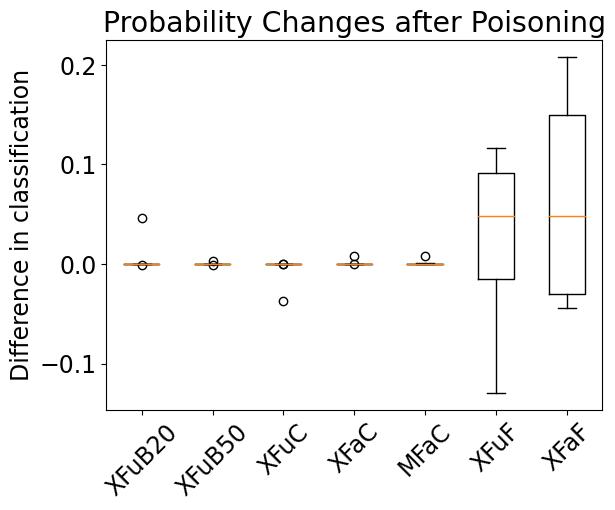

In [284]:
print(data)
plt.boxplot(data)
plt.ylabel('Difference in classification')
plt.title(f'Probability Changes after Poisoning')
plt.xticks([1,2,3,4,5,6,7], ['XFuB20', 'XFuB50', 'XFuC', 'XFaC', 'MFaC', 'XFuF', 'XFaF'], rotation=45)
plt.show()